In [1]:
# dependencies import
from common_dependencies import *
from typing import NamedTuple
#import model_versions as mv
import logging
logger = logging.getLogger(f'main.model_train')
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)
np.random.seed(290)
DataCrop = NamedTuple("DataCrop", [('left', int), ('top', int), ('width', int), ('height', int)])
DatasetPartDescription = NamedTuple("DatasetPartDescription", [('run_name', str), ('data_crop', DataCrop)])

2024-04-25 18:48:47.866502: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: FFT
2024-04-25 18:48:47.905928: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 18:48:48.328654: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: DNN


In [2]:
# train params that can be easily changed
# paths for files with original data
PATH_TO_DATA = {
    'run_1': 
        ('data/original_data/run_1/run1_WM32_data.csv',
        'data/original_data/run_1/run1_WM32_defects.csv',
        'data/original_data/run_1/run1_WM32_pipe.csv'),
    'run_2':
        ('data/original_data/run_2/run2_WM32_data.csv',
        'data/original_data/run_2/run2_WM32_defects.csv',
        'data/original_data/run_2/run2_WM32_pipe.csv')
}

MAX_VAL = 1000
XSHIFT = 200
train_dataset_desc = (DatasetPartDescription('run_1', DataCrop(0,0,MAX_VAL,MAX_VAL)),)

val_dataset_desc = (DatasetPartDescription('run_2', DataCrop(0,0,15000,40)),)
test_dataset_desc = (DatasetPartDescription('run_2', DataCrop(0,40,MAX_VAL,MAX_VAL)),)

In [3]:
#функция прикарманивания данных
def get_dataset_gen(path_to_data_tuple: tuple(),
                x_shift: int,
                data_part: DataCrop):
    logger.debug("start")

    # read data
    x_df, y_df = dw.get_x_and_y_data(*path_to_data_tuple)
    # roll data across x axis
    x_df = dw.roll_df(x_df, x_shift, 1)
    # slice certain data part
    x_df = x_df.iloc[data_part.top:data_part.top+data_part.height, data_part.left:data_part.left+data_part.width]
    # cast data from dataframe to numpy array
    x_arr = dw.df_to_numpy(x_df)
    # normalize data
    x_arr = np.concatenate([dw.normalize_data(x_arr[:,:,:32]), dw.normalize_data(x_arr[:,:,32:])],axis=2)
    # flat data from matrix of detector measures (64 values for each) to vector of measures
    x_arr = np.concatenate([row for row in x_arr], axis=0)
    
    logger.debug("end")

    return (x_arr,)

In [4]:
def concat_data_tuples(dataset_desc, xshift):
    # get output data tuple for each data part from dataset_desc
    data_tuples_arr = [get_dataset_gen(PATH_TO_DATA[desc_part.run_name], xshift, desc_part.data_crop) for desc_part in dataset_desc]
    # concat data tuples throught 1 axis (like concat every first item from all tuple into one first item of result tuple, same to second and etc.)
    # output tuple has the same quantity of values as every tuple got from previous step but each element of it is concatination of all elements
    # from that position from all read tuples
    return (*[np.concatenate(item,axis=0) for item in zip(*data_tuples_arr)],)

In [5]:
#входные и выходные данные
(train_x,) = concat_data_tuples(train_dataset_desc, XSHIFT)
(val_x,) = concat_data_tuples(val_dataset_desc, XSHIFT)
(test_x,) = concat_data_tuples(test_dataset_desc, XSHIFT) 

print('\nDatasets')
print(f'{train_x.shape=}, max={np.max(train_x)}, min={np.min(train_x)}')
print(f'{val_x.shape=}, max={np.max(val_x)}, min={np.min(val_x)}')
print(f'{test_x.shape=}, max={np.max(test_x)}, min={np.min(test_x)}')


Datasets
train_x.shape=(46000, 64), max=1.0, min=0.0
val_x.shape=(16000, 64), max=1.0, min=0.0
test_x.shape=(31600, 64), max=1.0, min=0.0


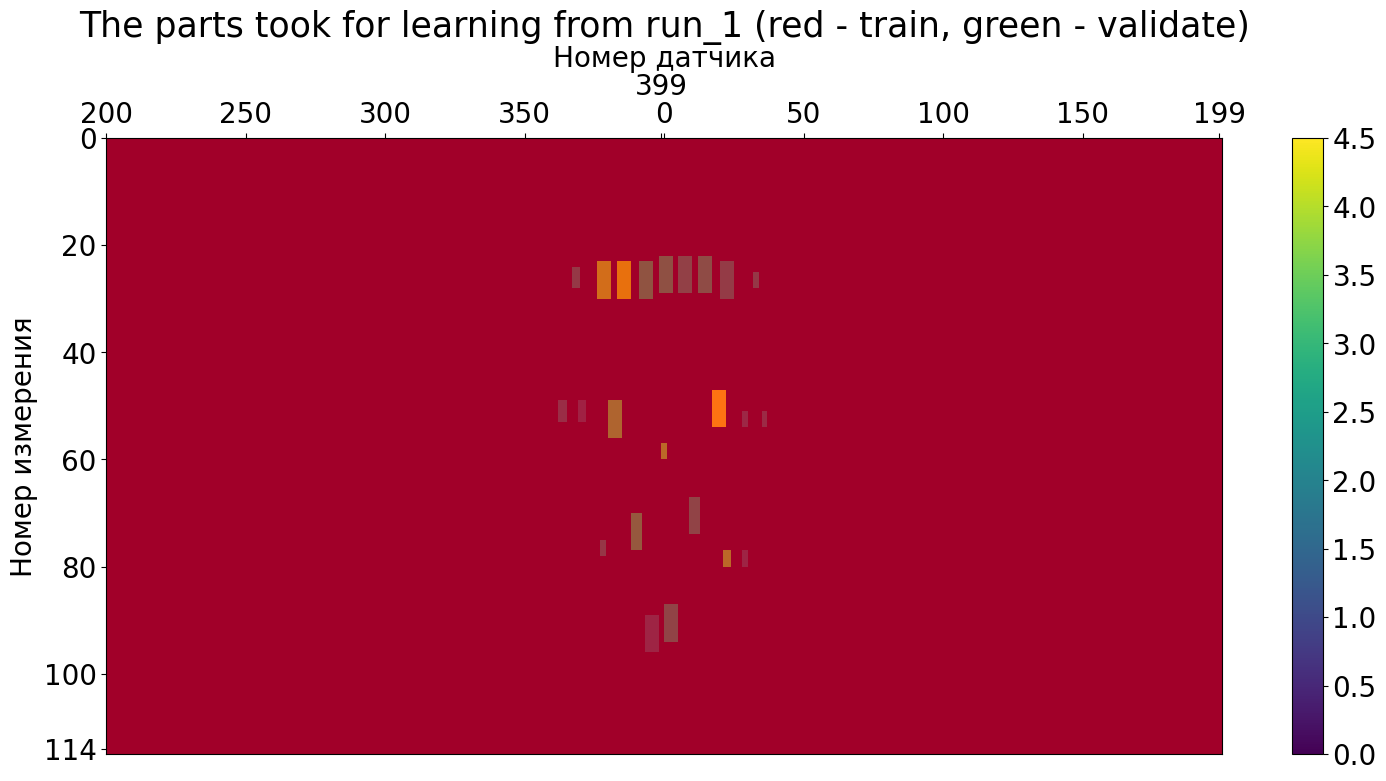

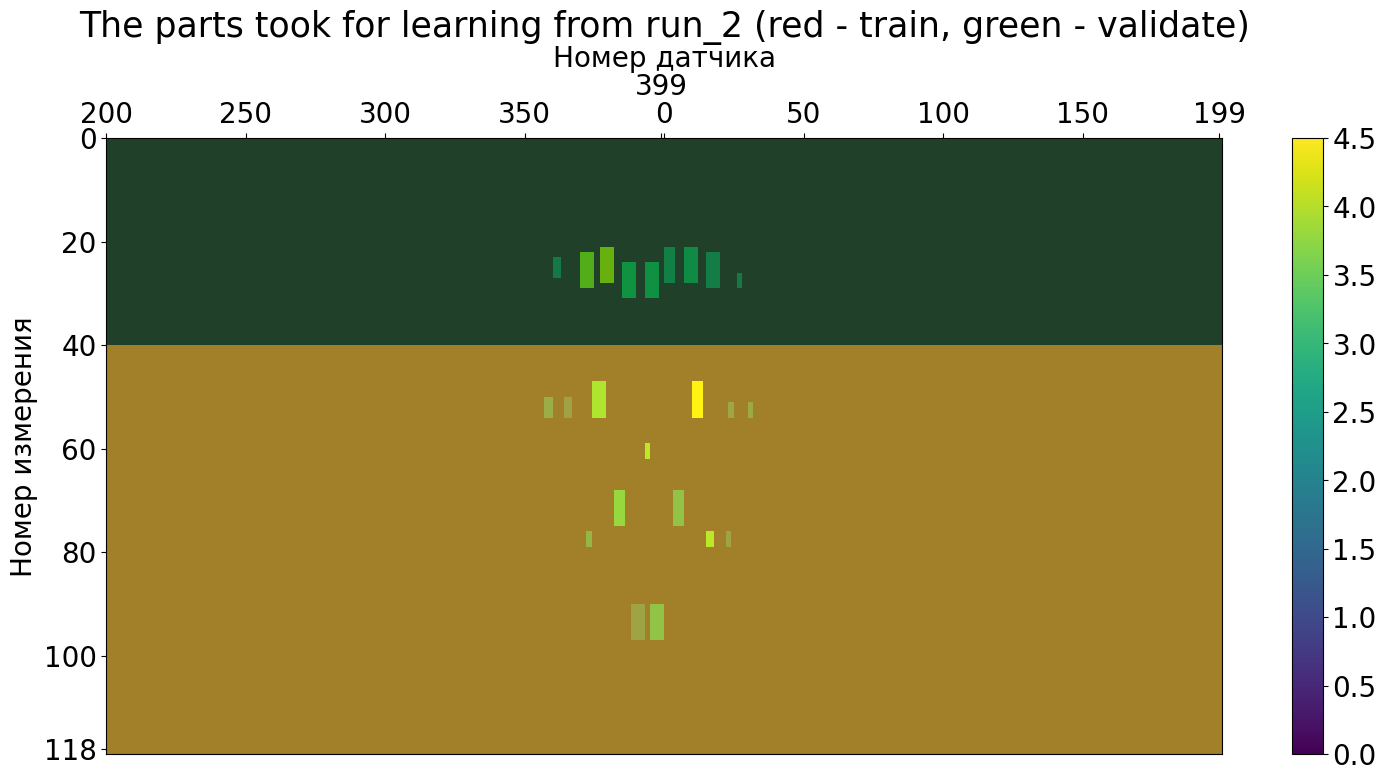

In [6]:
#выборка данных
# show parts took for learning
x_df1, y_df1 = dw.get_x_and_y_data(*PATH_TO_DATA['run_1'])
x_df2, y_df2 = dw.get_x_and_y_data(*PATH_TO_DATA['run_2'])
x_df1 = x_df2 = None

y_df1 = dw.roll_df(y_df1, XSHIFT, 1)
y_df2 = dw.roll_df(y_df2, XSHIFT, 1)

train_run_1_rects = []
train_run_2_rects = []
val_run_1_rects = []
val_run_2_rects = []
test_run_1_rects = []
test_run_2_rects = []

for data_desc in train_dataset_desc:
    if data_desc.run_name == 'run_1':
        train_run_1_rects.append(Rectangle((data_desc.data_crop.left, data_desc.data_crop.top), 
                                           data_desc.data_crop.width, data_desc.data_crop.height, facecolor='red', alpha=0.5))
    else:
        train_run_2_rects.append(Rectangle((data_desc.data_crop.left, data_desc.data_crop.top), 
                                           data_desc.data_crop.width, data_desc.data_crop.height, facecolor='red', alpha=0.5))

for data_desc in val_dataset_desc:
    if data_desc.run_name == 'run_1':
        val_run_1_rects.append(Rectangle((data_desc.data_crop.left, data_desc.data_crop.top), 
                                         data_desc.data_crop.width, data_desc.data_crop.height, facecolor='green', alpha=0.5))
    else:
        val_run_2_rects.append(Rectangle((data_desc.data_crop.left, data_desc.data_crop.top), 
                                         data_desc.data_crop.width, data_desc.data_crop.height, facecolor='green', alpha=0.5))

for data_desc in test_dataset_desc:
    if data_desc.run_name == 'run_1':
        test_run_1_rects.append(Rectangle((data_desc.data_crop.left, data_desc.data_crop.top), 
                                         data_desc.data_crop.width, data_desc.data_crop.height, facecolor='yellow', alpha=0.5))
    else:
        test_run_2_rects.append(Rectangle((data_desc.data_crop.left, data_desc.data_crop.top), 
                                         data_desc.data_crop.width, data_desc.data_crop.height, facecolor='yellow', alpha=0.5))


dw.draw_defects_map_with_rectangles_owerlap(y_df1, train_run_1_rects+val_run_1_rects+test_run_1_rects, title = f'The parts took for learning from run_1 (red - train, green - validate)')
dw.draw_defects_map_with_rectangles_owerlap(y_df2, train_run_2_rects+val_run_2_rects+test_run_2_rects, title = f'The parts took for learning from run_2 (red - train, green - validate)')

In [7]:
#### всякие константы для последующей работы

#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.00002 #0.0000002 # шаг сходимости back propogation
CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
#CMP_solver = keras.optimizers.SGD(CMP_learning_rate) # оптимизатор
CMP_loss_funcs = keras.losses.MeanSquaredError() #BinaryCrossentropy() 
#CMP_metrics = [keras.metrics.MeanSquaredError(name='MeanSquaredError')]
#///////////////////////////////// для колбэков

# для Early_stopping
ES_patience = 6 # кол-во эпох без улучшений
ES_min_delta = 0.0001 # минимальное улучшение параметра за cur_patience
ES_monitor_parametr =  'val_loss' # отслеживаемый параметр 
ES_save_best_weights = False # сохранять ли веса нейронки с лучшими результатами
#Es_mode = 'max'

   # для ReduceLROnPlateau
RLPOP_monitor_parametr = 'loss'  # отслеживаемый параметр 
RLPOP_factor = 0.3 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
RLPOP_patience = 1 # кол-во эпох без улучшений
RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
RLPOP_min_delta = 0.001 # порог изменения отслеживаемого значения
RLPOP_cooldown = 2 # количество эпох до возобновления работы после изменения шага сходимости
RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
#///////////////////////////////// для тренировки

FIT_batch_size = 4 # размерpython concat lists bach при обучении/тестировании1
#FIT_shuffle = True # перемешивать ли данные
FIT_verbose = True # выводить ли прогресс обучения в его процессее
FIT_epochs = 30 # количество эпох обучения
#FIT_validation_split = 0.10 #0.20 # процент валидационных данных, отсекаемых из тестовой выборки

2024-04-25 18:49:04.937431: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 18:49:04.959300: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 18:49:04.959357: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 18:49:04.960902: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 18:49:04.960976: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

In [8]:
#шараш-монтаж модели сети
enc_input = Input((64,), name='enc_input')
d = Dense(64, activation='linear')(enc_input)
d = Dense(32, activation='linear')(d)
d = Dense(16, activation='linear')(d)
d = Dense(8, activation='linear')(d)
#d = Dense(4, activation='linear')(d)
enc_output = Dense(4, activation='linear', name='enc_output')(d)

dec_input = Dense(8, activation='linear', name='dec_input')(enc_output)
d = Dense(16, activation='linear')(dec_input)
d = Dense(32, activation='linear')(d)
dec_output = Dense(64, activation='linear', name='dec_output')(d)

ae = keras.Model(enc_input, dec_output, name='vae')
ae.compile(optimizer=CMP_solver, loss=CMP_loss_funcs)

print(ae.summary())

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ enc_input (InputLayer)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_output (Dense)              │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_input (Dense)               │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_output (Dense)              │ (None, 64)             │         2,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,780 (38.20 KB)

 Trainable params: 9,780 (38.20 KB)

 Non-trainable params: 0 (0.00 B)

None


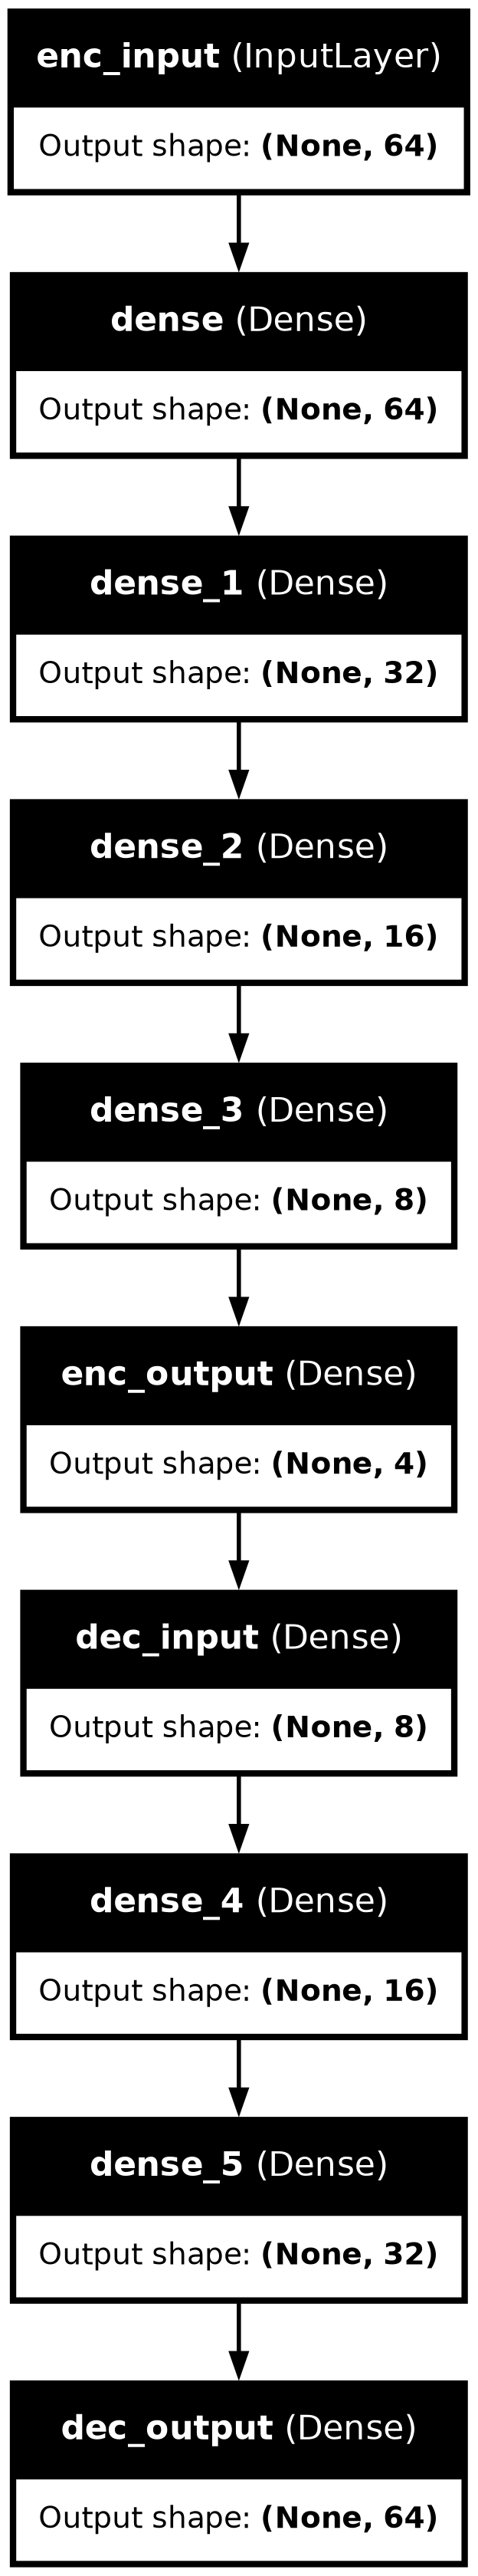

In [9]:
#визуализация сети в виде графа
tf.keras.utils.plot_model(
    ae,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False,
)

In [10]:

# Создание и настройка колбэков

callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

temp = keras.callbacks.EarlyStopping(
            monitor = ES_monitor_parametr, 
            min_delta = ES_min_delta, 
            patience = ES_patience,
            restore_best_weights = ES_save_best_weights
            )
callback_list.append(temp)

temp = keras.callbacks.ReduceLROnPlateau(
            monitor = RLPOP_monitor_parametr, 
            factor = RLPOP_factor, 
            patience = RLPOP_patience, 
            verbose = RLPOP_verbose,
            mode = RLPOP_mode, 
            min_delta = RLPOP_min_delta, 
            cooldown = RLPOP_cooldown, 
            min_lr = RLPOP_min_lr
            )
callback_list.append(temp)

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = ae## тут был model
            )

In [11]:
history = ae.fit(train_x, train_x,
                    batch_size = FIT_batch_size, 
                    epochs = FIT_epochs, 
                    verbose = FIT_verbose, 
                    shuffle=True,
                    validation_data = (val_x, val_x), 
                    callbacks = FIT_callback_list)

I0000 00:00:1714045747.171506   20607 service.cc:145] XLA service 0x5dbdd72b1b10 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714045747.171526   20607 service.cc:153]   StreamExecutor device (0): Radeon RX 7900 XT, AMDGPU ISA version: gfx1100


     98/Unknown 9s 1ms/step - loss: 0.4370

I0000 00:00:1714045754.418473   20607 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11500/11500 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - loss: 0.1396 - val_loss: 0.0359 - learning_rate: 2.0000e-05
11500/11500 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0310 - val_loss: 0.0249 - learning_rate: 2.0000e-05
11500/11500 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0217 - val_loss: 0.0225 - learning_rate: 2.0000e-05
11479/11500 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0205
Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.
11500/11500 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0205 - val_loss: 0.0225 - learning_rate: 2.0000e-05
11500/11500 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0204 - val_loss: 0.0225 - learning_rate: 6.0000e-06
11477/11500 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0204
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.7999999272433341e-06.
11500/11500 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 6.0000e-06
11500/11500 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0204 - val_loss: 0.0224

In [12]:
res = ae.evaluate(test_x, test_x, batch_size = 32, return_dict=True)
print(res)

988/988 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0197 
{'loss': 0.01959228515625}


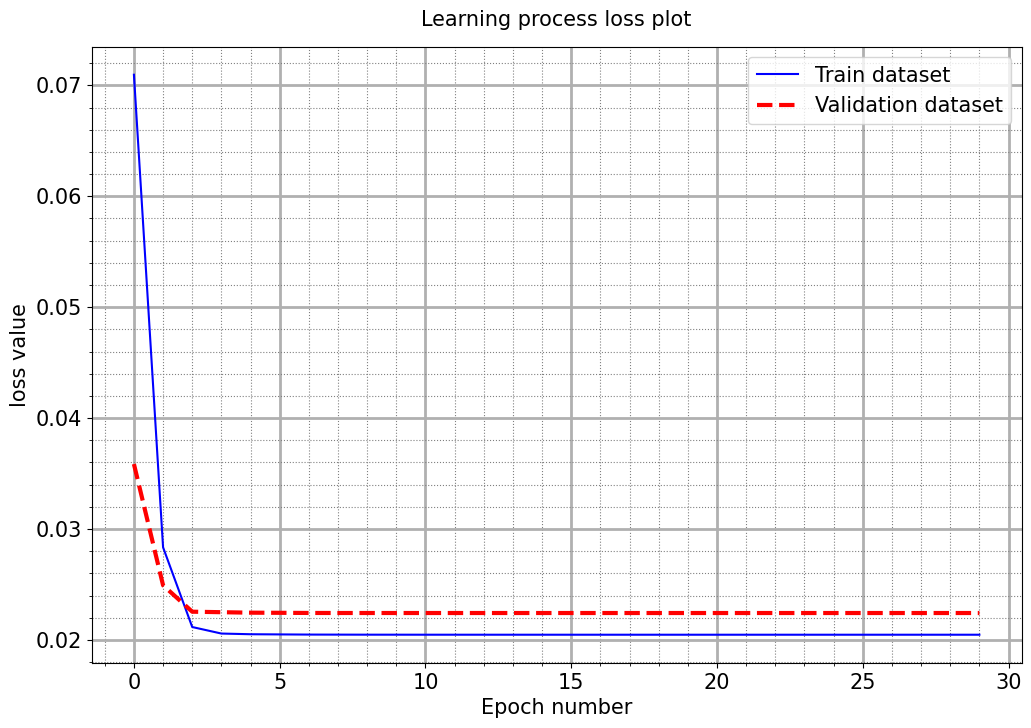

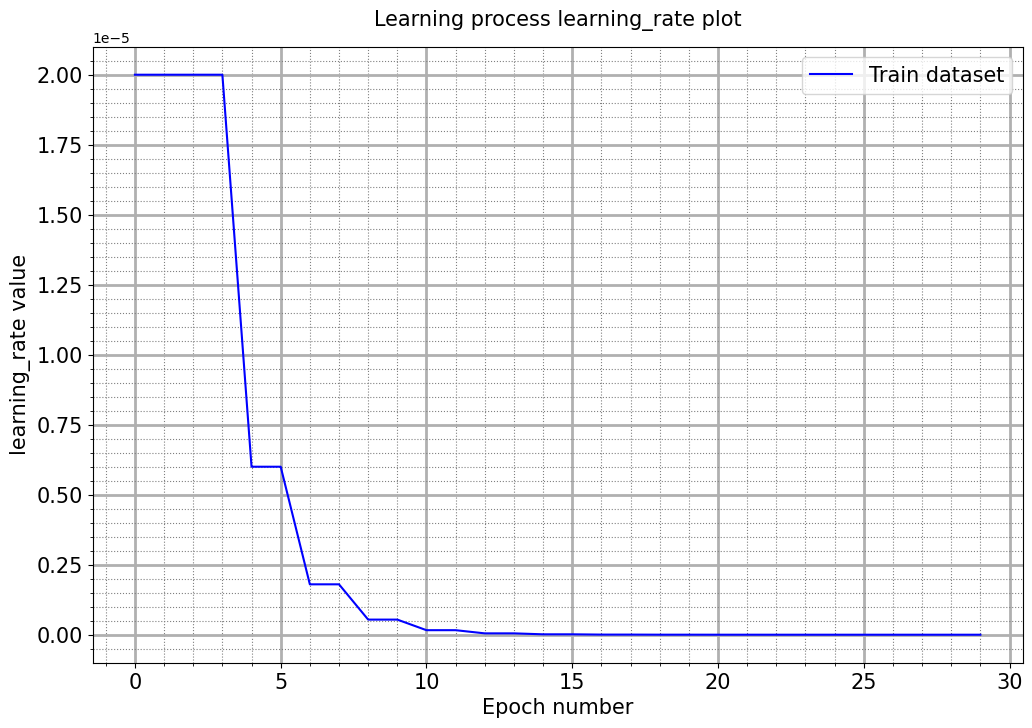

In [13]:
FONT_SIZE = 15
for key in [k for k in history.history.keys() if not k.startswith('val')]:
    fig, ax = plt.subplots()

    fig.set_figwidth(12)
    fig.set_figheight(8)
    
    plt.plot(history.history[key], 
             label='Train dataset',  linewidth=1.5, color='blue')
    if not key == 'learning_rate':
        plt.plot(history.history[f'val_{key}'], linestyle = '--', 
             label='Validation dataset',  linewidth=3, color='red')
    
    ax.set_xlabel('Epoch number', fontsize=FONT_SIZE)
    ax.set_ylabel(f'{key} value', fontsize=FONT_SIZE)
    ax.set_title(f"Learning process {key} plot", fontsize=FONT_SIZE, pad=15)
    
    ax.patch.set_alpha(0)
    
    #  Устанавливаем форматирование делений:
    ax.tick_params(axis='both', which='both', labelsize = FONT_SIZE)
    
    # Вывод и настройка сетки
    ax.minorticks_on()
    ax.grid(which='major', linewidth=2)
    ax.grid(which='minor', color = 'gray', linestyle = ':')
    
    ax.legend(fontsize = FONT_SIZE, facecolor = "white", loc = 'upper right')
    
    plt.show()

In [23]:
# сохранение модели в файл
#import h5py
#from tensorflow.keras.models import load_model
ae.save(f"networks/AE/id=v01n01_loss(train={history.history['loss'][-1]:.4f},val={history.history['val_loss'][-1]:.4f},test={res['loss']:.4f}).keras")